In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import json
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import glob

In [2]:
def calculate_pckh(results):
    okss = [[] for _ in range(20)]
    pixel_errors = [[] for _ in range(20)]
    percentage_errors = [[] for _ in range(20)]

    for res in results:
        pred = res['pred_instances']['keypoints'][0]
        gt = res['gt_instances']['keypoints'][0]
        keypoints_visible = res['gt_instances']['keypoints_visible'][0]
        bbox = res['gt_instances']['bboxes'][0]
        w = bbox[2] - bbox[0]
        h = bbox[3] - bbox[1]
        area = w*h

        head_size = np.linalg.norm(gt[4] - gt[5])

        for i in range(20):
            if not keypoints_visible[i]:
                continue

            for thresh in np.arange(.5, 1, .05):
                a = gt[i]
                b = pred[i]
                distance = np.linalg.norm(a - b)
                oks = np.exp(-distance**2 / (2 * (np.sqrt(area) * 0.06) ** 2)) # oks = np.exp(-d**2 / (2 * (s * k) ** 2)) => k = .1
                
                if oks < thresh:
                    continue
                
                okss[i].append(oks)
                pixel_errors[i].append(distance)
                percentage_errors[i].append(np.linalg.norm(a - b) / head_size)
    
    # print(okss)
    # print([len(o) for o in okss])

    mean_pixel_errors = np.array([np.nanmean(e) for e in pixel_errors]).astype(np.float32)
    mean_percentage_errors = np.array([np.nanmean(e) if len(e) > 0.0 else 1 for e in percentage_errors]).astype(np.float32)
    mean_okss = np.array([np.nanmean(o) for o in okss]).astype(np.float32)
    return mean_pixel_errors, mean_percentage_errors, mean_okss

In [3]:
with open('../models/_train-2024-08-15_05-25-27-real/20240815_053109/results/real.pkl', 'rb') as f:
    real_res = pickle.load(f)

with open('../models/_train-2024-08-15_05-08-10-synthetic/20240815_060736/results/synthetic.pkl', 'rb') as f:
    synthetic_res = pickle.load(f)

with open('../models/_train-2024-08-15_05-43-51-real-on-synthetic/20240815_054927/results/real_on_synthetic.pkl', 'rb') as f:
    combined_res = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '../models/_train-2024-08-15_05-25-27-real/20240815_053109/results/real.pkl'

In [4]:
def calculate_oks(results):
    okss = [[] for _ in range(20)]
    pixel_errors = [[] for _ in range(20)]
    percentage_errors = [[] for _ in range(20)]

    for res in results:
        pred = res['pred_instances']['keypoints'][0]
        gt = res['gt_instances']['keypoints'][0]
        scores = res['pred_instances']['keypoint_scores'][0]
        bbox = res['gt_instances']['bboxes'][0]
        w = bbox[2] - bbox[0]
        h = bbox[3] - bbox[1]
        area = w*h

        head_size = np.linalg.norm(gt[4] - gt[5])

        for i in range(20):
            for thresh in np.arange(.5, 1, .05):
                # if scores[i] < thresh:
                #     continue
                a = gt[i]
                b = pred[i]
                distance = np.linalg.norm(a - b)
                oks = np.exp(-distance**2 / (2 * (np.sqrt(area) * .1) ** 2)) # oks = np.exp(-d**2 / (2 * (s * k) ** 2)) => k = .1
                
                if oks < thresh:
                    continue
                
                okss[i].append(oks)
    
    mean_okss = np.array([np.nanmean(o) for o in okss]).astype(np.float32)
    return np.mean(mean_okss)

In [2]:
def compute_oks_per_keypoint(coco_gt, coco_dt):
    # Initialize COCOeval object
    coco_eval = COCOeval(coco_gt, coco_dt, iouType='keypoints')

    # Set image and category IDs to evaluate (use all by default)
    coco_eval.params.kpt_oks_sigmas = np.ones((20,)) * .1
    coco_eval.params.imgIds = coco_gt.getImgIds()
    coco_eval.params.catIds = coco_gt.getCatIds()

    # Run evaluation
    coco_eval.evaluate()

    # Extract information needed for OKS computation
    gts = coco_eval._gts  # Ground truth annotations
    dts = coco_eval._dts  # Detection results

    sigmas = coco_eval.params.kpt_oks_sigmas  # Keypoint-specific variances
    vars = (sigmas * 2) ** 2

    oks_per_keypoint = []

    # Iterate through all image-category pairs
    for imgId in coco_eval.params.imgIds:
        for catId in coco_eval.params.catIds:
            if (imgId, catId) in gts:
                gt_list = gts[imgId, catId]
                dt_list = dts[imgId, catId]

                if not gt_list or not dt_list:
                    continue

                # Sort detections by score
                dt_list = sorted(dt_list, key=lambda x: -x['score'])

                # Limit detections to the maximum allowed
                dt_list = dt_list[:coco_eval.params.maxDets[-1]]

                for gt in gt_list:
                    gt_keypoints = np.array(gt['keypoints']).reshape(-1, 3)
                    gt_area = gt['area']
                    gt_vis = np.array(gt['keypoints'])[2::3]

                    for dt in dt_list:
                        dt_keypoints = np.array(dt['keypoints']).reshape(-1, 3)

                        # Compute the distance between corresponding keypoints
                        dx = dt_keypoints[:, 0] - gt_keypoints[:, 0]
                        dy = dt_keypoints[:, 1] - gt_keypoints[:, 1]
                        e = (dx ** 2 + dy ** 2) / vars / (gt_area + np.spacing(1)) / 2

                        # Calculate OKS per keypoint wheer keypopint is visible
                        oks = np.exp(-e)
                        oks[gt_vis < 1] = np.nan
                        oks_per_keypoint.append(oks)

    # Calculate average OKS for each keypoint across all images
    oks_per_keypoint = np.array(oks_per_keypoint)
    mean_oks_per_keypoint = np.nanmean(oks_per_keypoint, axis=0)

    return mean_oks_per_keypoint


def calculate_pixel_distance(coco_gt, coco_dt):
    # Initialize a dictionary to store distances for each keypoint
    keypoint_distances = []
    normalized_distances = []

    # Iterate through all image-category pairs
    for imgId in coco_gt.getImgIds():
        for catId in coco_gt.getCatIds():
            gt_list = coco_gt.loadAnns(coco_gt.getAnnIds(imgIds=[imgId], catIds=[catId], iscrowd=False))
            dt_list = coco_dt.loadAnns(coco_dt.getAnnIds(imgIds=[imgId], catIds=[catId]))

            if not gt_list or not dt_list:
                continue

            # Sort detections by score
            dt_list = sorted(dt_list, key=lambda x: -x['score'])

            for gt in gt_list:
                gt_keypoints = np.array(gt['keypoints']).reshape(-1, 3)  # Shape: [num_keypoints, 3]
                head_length = np.sqrt(  # We consider head length as the distance betweeen Head (kp#4) and Nose (kp#5) 
                    (gt_keypoints[4][0] - gt_keypoints[5][0]) ** 2 +
                    (gt_keypoints[4][1] - gt_keypoints[5][1]) ** 2
                )
                gt_vis = np.array(gt['keypoints'])[2::3]

                for dt in dt_list:
                    dt_keypoints = np.array(dt['keypoints']).reshape(-1, 3)  # Shape: [num_keypoints, 3]

                    # Calculate the pixel distance for each visible keypoint
                    distances = np.sqrt(
                        (dt_keypoints[:, 0] - gt_keypoints[:, 0]) ** 2 +
                        (dt_keypoints[:, 1] - gt_keypoints[:, 1]) ** 2
                    )

                    distances[gt_vis < 1] = np.nan

                    keypoint_distances.append(distances)
                    normalized_distances.append(distances / head_length)

    # Convert to numpy array for easier handling
    keypoint_distances = np.array(keypoint_distances)
    normalized_distances = np.array(normalized_distances)

    # Calculate the average distance for each keypoint across all images
    mean_distances_per_keypoint = np.nanmean(keypoint_distances, axis=0)
    mean_normalized_distances_per_keypoint = np.nanmean(normalized_distances, axis=0)

    return mean_distances_per_keypoint, mean_normalized_distances_per_keypoint


In [3]:
coco_gt = COCO('../datasets/annotations/20kp-test.json')

real_oks = []
syn_oks = []
combined_oks = []

real_pixel = []
syn_pixel = []
combined_pixel = []

real_percentage = []
syn_percentage = []
combined_percentage = []

for real, syn, combined in zip(sorted(glob.glob('../test_results_5fold/*real_simillar_fold.json')),
                               sorted(glob.glob('../test_results_5fold/*synthetic_varied_fold.json')),
                               sorted(glob.glob('../test_results_5fold/*synthetic_on_real_fold.json'))):
    real_dt = coco_gt.loadRes(real)
    synthetic_dt = coco_gt.loadRes(syn)
    combined_dt = coco_gt.loadRes(combined)

    real_oks.append(compute_oks_per_keypoint(coco_gt, real_dt))
    syn_oks.append(compute_oks_per_keypoint(coco_gt, synthetic_dt))
    combined_oks.append(compute_oks_per_keypoint(coco_gt, combined_dt))

    pixel_results = calculate_pixel_distance(coco_gt, real_dt)
    real_pixel.append(pixel_results[0])
    real_percentage.append(pixel_results[1])

    pixel_results = calculate_pixel_distance(coco_gt, synthetic_dt)
    syn_pixel.append(pixel_results[0])
    syn_percentage.append(pixel_results[1])

    pixel_results = calculate_pixel_distance(coco_gt, combined_dt)
    combined_pixel.append(pixel_results[0])
    combined_percentage.append(pixel_results[1])


real_oks_per_kp = np.mean(real_oks, axis=0)
synthetic_oks_per_kp = np.mean(syn_oks, axis=0)
combined_oks_per_kp = np.mean(combined_oks, axis=0)
real_pixel_distance = np.mean(real_pixel, axis=0)
synthetic_pixel_distance = np.mean(syn_pixel, axis=0)
combined_pixel_distance = np.mean(combined_pixel, axis=0)
real_pixel_percentage = np.mean(real_percentage, axis=0)
synthetic_pixel_percentage = np.mean(syn_percentage, axis=0)
combined_pixel_percentage = np.mean(combined_percentage, axis=0)


Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.00s).
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.01s).
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.00s).
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.00s).
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.00s).
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.00s).
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.00s).
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.00s).
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.00s).
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.00s).
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.00s).
Running per image evaluation...
Evaluate annotation type *keypoin

### Back points

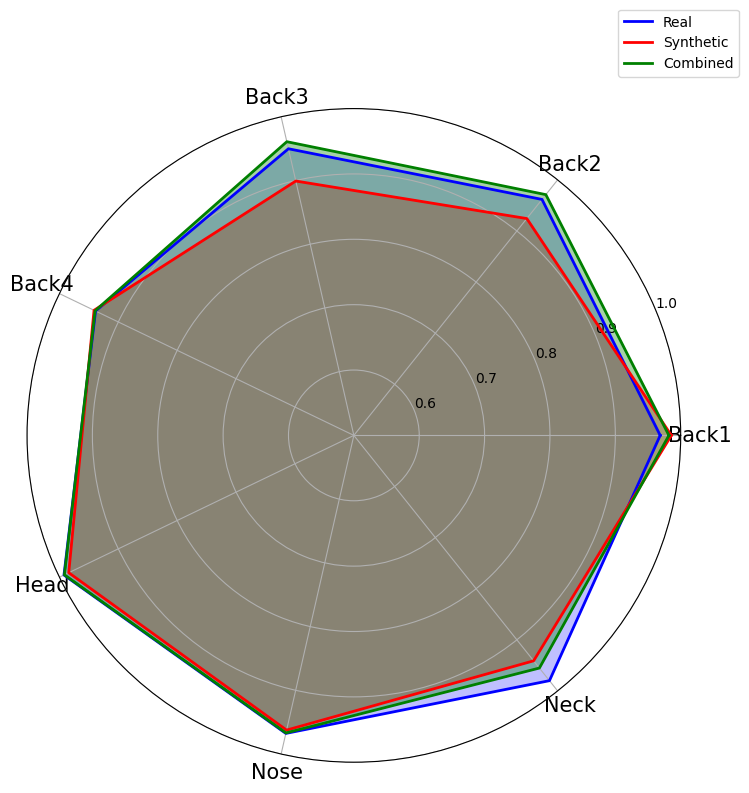

In [124]:
import numpy as np
import matplotlib.pyplot as plt

# Data for the first plot (Upper KPs)
real_oks_upper = real_oks_per_kp[:7]
synthetic_oks_upper = synthetic_oks_per_kp[:7]
combined_oks_upper = combined_oks_per_kp[:7]

keypoints_upper = ["Back1", "Back2", "Back3", "Back4", "Head", "Nose", "Neck"]
num_vars_upper = len(real_oks_upper)
angles_upper = np.linspace(0, 2 * np.pi, num_vars_upper, endpoint=False).tolist()

values1_upper = np.concatenate((real_oks_upper, [real_oks_upper[0]]))
values2_upper = np.concatenate((synthetic_oks_upper, [synthetic_oks_upper[0]]))
values3_upper = np.concatenate((combined_oks_upper, [combined_oks_upper[0]]))
angles_upper += angles_upper[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})
ax.fill(angles_upper, values1_upper, color='blue', alpha=0.25)
ax.plot(angles_upper, values1_upper, color='blue', linewidth=2, label='Real')
ax.fill(angles_upper, values2_upper, color='red', alpha=0.30)
ax.plot(angles_upper, values2_upper, color='red', linewidth=2, label='Synthetic')
ax.fill(angles_upper, values3_upper, color='green', alpha=0.35)
ax.plot(angles_upper, values3_upper, color='green', linewidth=2, label='Combined')
ax.set_xticks(angles_upper[:-1])
ax.set_xticklabels(keypoints_upper, fontsize=15)
plt.ylim(.5, 1)
plt.legend(loc='right', bbox_to_anchor=(1.1, 1.1))
# plt.title('Upper KPs', size=16, color='darkblue', pad=20)
plt.savefig('figures/upper-oks.png')
plt.tight_layout()
plt.show()

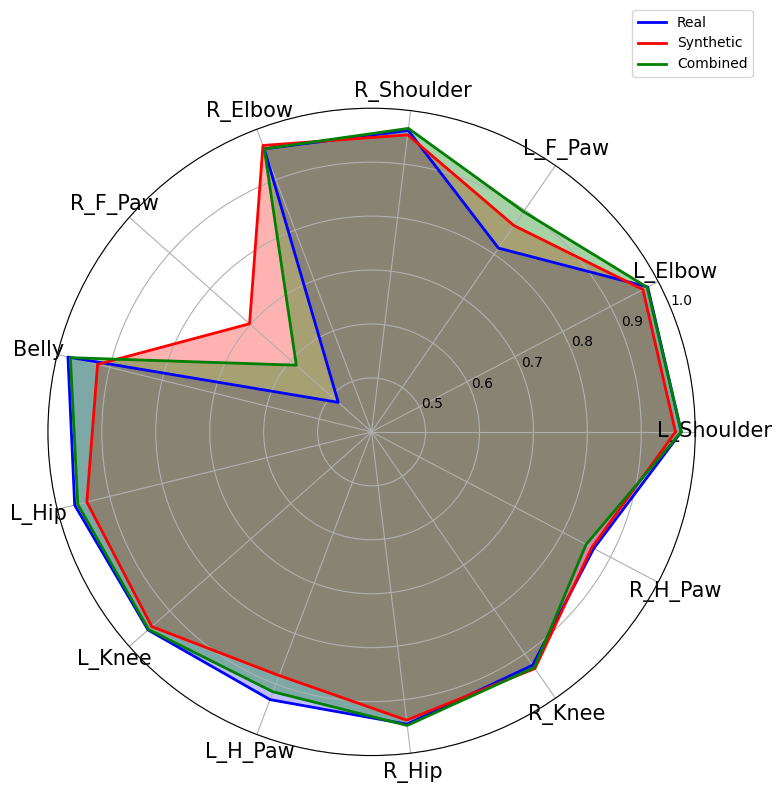

In [153]:
# Data for the second plot (Lower KPs)
real_oks_lower = real_oks_per_kp[7:]
synthetic_oks_lower = synthetic_oks_per_kp[7:]
combined_oks_lower = combined_oks_per_kp[7:]

keypoints_lower = [
    "L_Shoulder", "L_Elbow", "L_F_Paw", "R_Shoulder", "R_Elbow",
    "R_F_Paw", "Belly", "L_Hip", "L_Knee", "L_H_Paw", "R_Hip",
    "R_Knee", "R_H_Paw"
]
num_vars_lower = len(real_oks_lower)
angles_lower = np.linspace(0, 2 * np.pi, num_vars_lower, endpoint=False).tolist()

values1_lower = np.concatenate((real_oks_lower, [real_oks_lower[0]]))
values2_lower = np.concatenate((synthetic_oks_lower, [synthetic_oks_lower[0]]))
values3_lower = np.concatenate((combined_oks_lower, [combined_oks_lower[0]]))
angles_lower += angles_lower[:1]

# Create the subplots side by side
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

ax.fill(angles_lower, values1_lower, color='blue', alpha=0.25)
ax.plot(angles_lower, values1_lower, color='blue', linewidth=2, label='Real')
ax.fill(angles_lower, values2_lower, color='red', alpha=0.30)
ax.plot(angles_lower, values2_lower, color='red', linewidth=2, label='Synthetic')
ax.fill(angles_lower, values3_lower, color='green', alpha=0.35)
ax.plot(angles_lower, values3_lower, color='green', linewidth=2, label='Combined')
ax.set_xticks(angles_lower[:-1])
ax.set_xticklabels(keypoints_lower, fontsize=15)
ax.set_ylim(.4, 1)
# ax.set_title('Lower KPs', size=16, color='darkblue', pad=20)
ax.legend(loc='right', bbox_to_anchor=(1.1, 1.1))

# Adjust layout and show the plots
plt.tight_layout()
plt.savefig('figures/lower-oks.png')
plt.show()

### Head and Belly

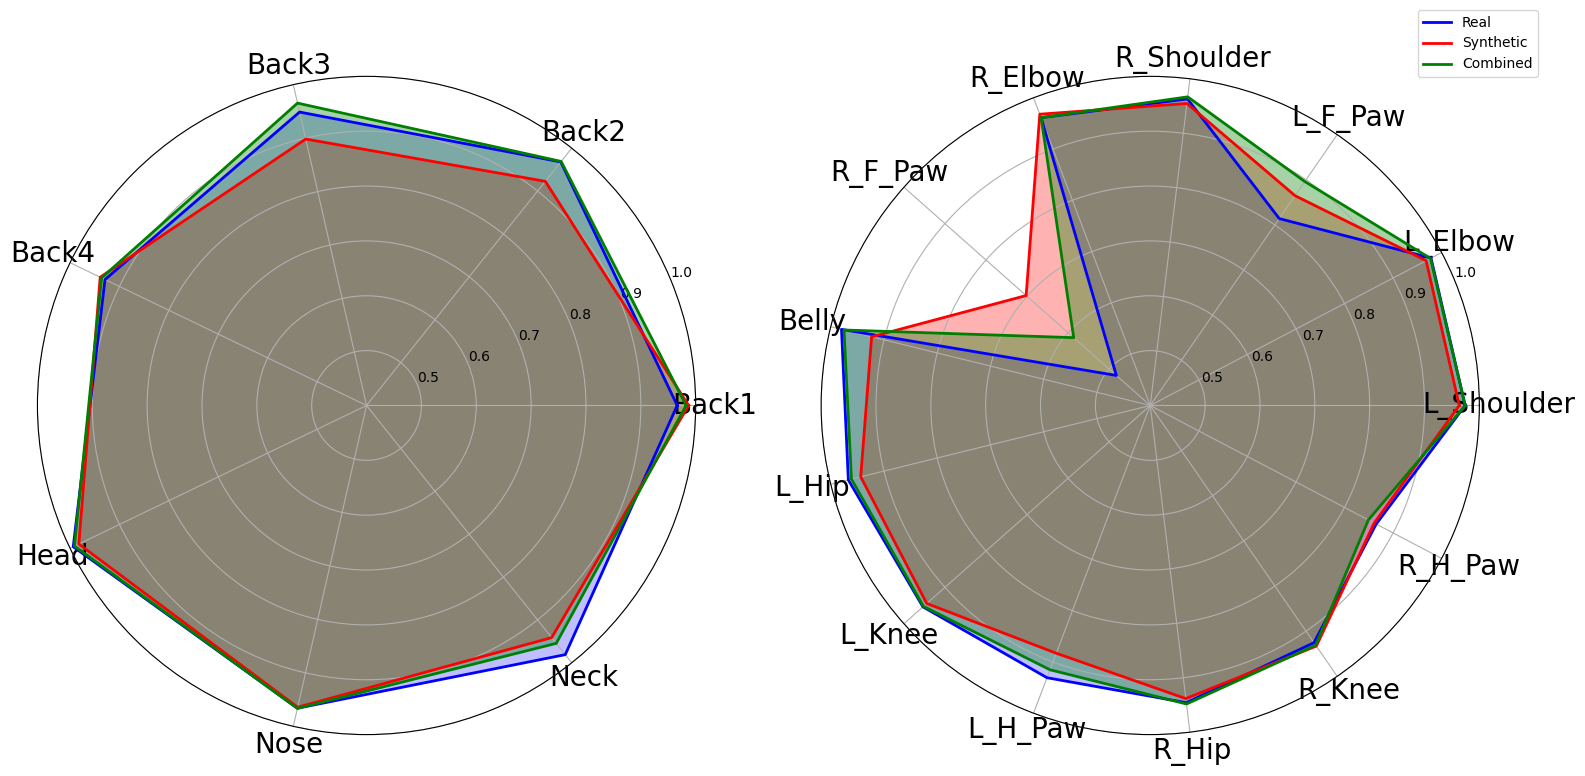

In [204]:
import numpy as np
import matplotlib.pyplot as plt

# Data for the first plot (Upper KPs)
real_oks_upper = real_oks_per_kp[:7]
synthetic_oks_upper = synthetic_oks_per_kp[:7]
combined_oks_upper = combined_oks_per_kp[:7]

keypoints_upper = ["Back1", "Back2", "Back3", "Back4", "Head", "Nose", "Neck"]
num_vars_upper = len(real_oks_upper)
angles_upper = np.linspace(0, 2 * np.pi, num_vars_upper, endpoint=False).tolist()

values1_upper = np.concatenate((real_oks_upper, [real_oks_upper[0]]))
values2_upper = np.concatenate((synthetic_oks_upper, [synthetic_oks_upper[0]]))
values3_upper = np.concatenate((combined_oks_upper, [combined_oks_upper[0]]))
angles_upper += angles_upper[:1]

# Data for the second plot (Lower KPs)
real_oks_lower = real_oks_per_kp[7:]
synthetic_oks_lower = synthetic_oks_per_kp[7:]
combined_oks_lower = combined_oks_per_kp[7:]

keypoints_lower = [
    "L_Shoulder", "L_Elbow", "L_F_Paw", "R_Shoulder", "R_Elbow",
    "R_F_Paw", "Belly", "L_Hip", "L_Knee", "L_H_Paw", "R_Hip",
    "R_Knee", "R_H_Paw"
]
num_vars_lower = len(real_oks_lower)
angles_lower = np.linspace(0, 2 * np.pi, num_vars_lower, endpoint=False).tolist()

values1_lower = np.concatenate((real_oks_lower, [real_oks_lower[0]]))
values2_lower = np.concatenate((synthetic_oks_lower, [synthetic_oks_lower[0]]))
values3_lower = np.concatenate((combined_oks_lower, [combined_oks_lower[0]]))
angles_lower += angles_lower[:1]

# Create the subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), subplot_kw=dict(polar=True))

# Plot for Upper KPs
ax1.fill(angles_upper, values1_upper, color='blue', alpha=0.25)
ax1.plot(angles_upper, values1_upper, color='blue', linewidth=2, label='Real')
ax1.fill(angles_upper, values2_upper, color='red', alpha=0.30)
ax1.plot(angles_upper, values2_upper, color='red', linewidth=2, label='Synthetic')
ax1.fill(angles_upper, values3_upper, color='green', alpha=0.35)
ax1.plot(angles_upper, values3_upper, color='green', linewidth=2, label='Combined')
ax1.set_xticks(angles_upper[:-1])
ax1.set_xticklabels(keypoints_upper, fontsize=20)
ax1.set_ylim(.4, 1)
# ax1.set_title('Upper KPs', size=16, color='darkblue', pad=20)
# ax1.legend(loc='lower right', bbox_to_anchor=(1.1, 1.1))

# Plot for Lower KPs
ax2.fill(angles_lower, values1_lower, color='blue', alpha=0.25)
ax2.plot(angles_lower, values1_lower, color='blue', linewidth=2, label='Real')
ax2.fill(angles_lower, values2_lower, color='red', alpha=0.30)
ax2.plot(angles_lower, values2_lower, color='red', linewidth=2, label='Synthetic')
ax2.fill(angles_lower, values3_lower, color='green', alpha=0.35)
ax2.plot(angles_lower, values3_lower, color='green', linewidth=2, label='Combined')
ax2.set_xticks(angles_lower[:-1])
ax2.set_xticklabels(keypoints_lower, fontsize=20)
ax2.set_ylim(.4, 1)
# ax2.set_title('Lower KPs', size=16, color='darkblue', pad=20)
ax2.legend(loc='right', bbox_to_anchor=(1.1, 1.05))

# Adjust layout and show the plots
plt.tight_layout()
plt.savefig('figures/kps-oks.svg')
plt.savefig('figures/kps-oks.png')
plt.show()


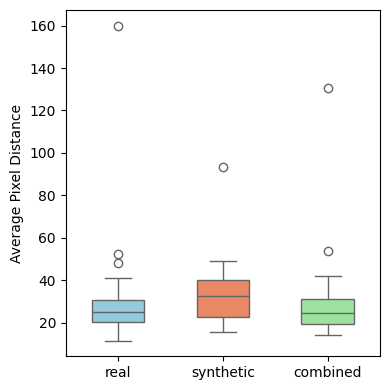

In [74]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Create a pandas DataFrame
data = {
    'real': real_pixel_distance,
    'synthetic': synthetic_pixel_distance,
    'combined': combined_pixel_distance
}

df = pd.DataFrame(data)

# Custom colors for the boxplot
colors = ['#87CEEB', '#FF7F50', '#90EE90']

fig = plt.figure(figsize=(4,4))


# Create a boxplot using seaborn with custom colors
sns.boxplot(data=df, palette=colors, width=.5)

# Add labels and title
# plt.xlabel('Categories')
plt.ylabel('Average Pixel Distance')
# plt.title('Boxplot of Real, Synthetic, and Combined Data')

# Show the plot
plt.tight_layout()
plt.savefig('figures/boxplot.png')
plt.show()


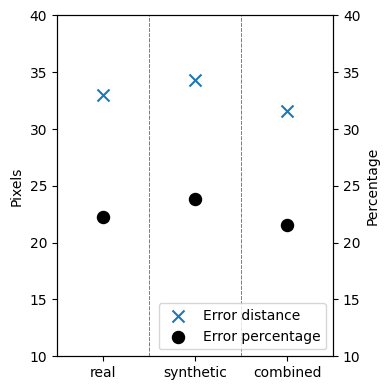

In [73]:
categories = ['real', 'synthetic', 'combined']
pixel_errors = [np.mean(real_pixel_distance), np.mean(synthetic_pixel_distance), np.mean(combined_pixel_distance)]  # For real, synthetic, and mixed
pixel_error_percentages = [np.mean(real_pixel_percentage) * 100, np.mean(synthetic_pixel_percentage) * 100, np.mean(combined_pixel_percentage) * 100]  # For real, synthetic, and mixed


fig, ax1 = plt.subplots(figsize=(4, 4))
scatter1 = ax1.scatter(categories, pixel_errors, marker='x', label='Error distance', s=75)
ax1.set_ylabel('Pixels')
ax1.set_ylim(10, 40)

ax2 = ax1.twinx()
scatter2 = ax2.scatter(categories, pixel_error_percentages, marker='o', label='Error percentage', s=75, color='black')
ax2.set_ylim(10, 40)
ax2.set_ylabel('Percentage')

category_indices = np.arange(len(categories))
for i in range(len(categories) - 1):
    x_pos = (i + i + 1) / 2
    plt.axvline(x=x_pos, color='grey', linestyle='--', linewidth=0.7)
    plt.axvline(x=x_pos, color='grey', linestyle='--', linewidth=0.7)

plt.xlim(-0.5, len(categories) - 0.5)

scatters = [scatter1, scatter2]
labels = [s.get_label() for s in scatters]
plt.legend(scatters, labels, loc='lower right')

plt.tight_layout()
plt.savefig('figures/average-px-distance.png')
plt.show()


In [46]:
real_ap_data = []
real_ar_data = []

for real_log in glob.glob('../test_results_5fold/logs/real*.json'):
    ap_data = []
    ar_data = []
    with open(real_log) as f:
        for line in f.readlines():
            obj = json.loads(line)
            if 'coco/AP' in obj.keys():
                ap_data.append(obj['coco/AP'])
                ar_data.append(obj['coco/AR'])
    real_ap_data.append(ap_data)
    real_ar_data.append(ar_data)


In [47]:
syn_ap_data = []
syn_ar_data = []

for syn_log in glob.glob('../test_results_5fold/logs/syn*.json'):
    ap_data = []
    ar_data = []
    with open(syn_log) as f:
        for line in f.readlines():
            obj = json.loads(line)
            if 'coco/AP' in obj.keys():
                ap_data.append(obj['coco/AP'])
                ar_data.append(obj['coco/AR'])
    syn_ap_data.append(ap_data)
    syn_ar_data.append(ar_data)


In [48]:
combined_ap_data = []
combined_ar_data = []

for syn_log in glob.glob('../test_results_5fold/logs/combined*.json'):
    ap_data = []
    ar_data = []
    with open(syn_log) as f:
        for line in f.readlines():
            obj = json.loads(line)
            if 'coco/AP' in obj.keys():
                ap_data.append(obj['coco/AP'])
                ar_data.append(obj['coco/AR'])
    combined_ap_data.append(ap_data)
    combined_ar_data.append(ar_data)


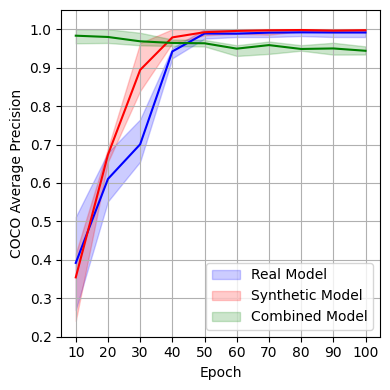

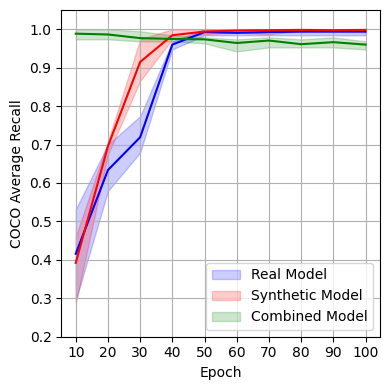

In [76]:
import numpy as np
import matplotlib.pyplot as plt

x_values = np.arange(1, len(real_ap_data[0]) + 1) * 10  # X-axis values (assuming these are epoch indices or model indices)
colors = ['blue', 'red', 'green']
labels = ['Real Model', 'Synthetic Model', 'Combined Model']

fig = plt.figure(figsize=(4,4))
plt.ylim(0.2, 1.05)
for ap_data, color, label in zip([real_ap_data, syn_ap_data, combined_ap_data], colors, labels):
    ap_array = np.array(ap_data)

    ap_mean = np.mean(ap_array, axis=0)
    ap_upper = np.max(ap_array, axis=0)
    ap_lower = np.min(ap_array, axis=0)

    plt.plot(x_values, ap_mean, color=color)
    plt.fill_between(x_values, ap_lower, ap_upper, color=color, alpha=0.2, label=label)

plt.xticks(x_values)
plt.xlabel('Epoch')
plt.ylabel('COCO Average Precision')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('figures/cocoap-training')
plt.show()




fig = plt.figure(figsize=(4,4))
plt.ylim(0.2, 1.05)
for ar_data, color, label in zip([real_ar_data, syn_ar_data, combined_ar_data], colors, labels):
    ar_array = np.array(ar_data)

    ar_mean = np.mean(ar_array, axis=0)
    ar_upper = np.max(ar_array, axis=0)
    ar_lower = np.min(ar_array, axis=0)

    plt.plot(x_values, ar_mean, color=color)
    plt.fill_between(x_values, ar_lower, ar_upper, color=color, alpha=0.2, label=label)

plt.xticks(x_values)
plt.xlabel('Epoch')
plt.ylabel('COCO Average Recall')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('figures/cocoar-training')
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '../models/_train-2024-08-15_05-43-51-real-on-synthetic/20240815_054353/vis_data/COCO-combined.json'

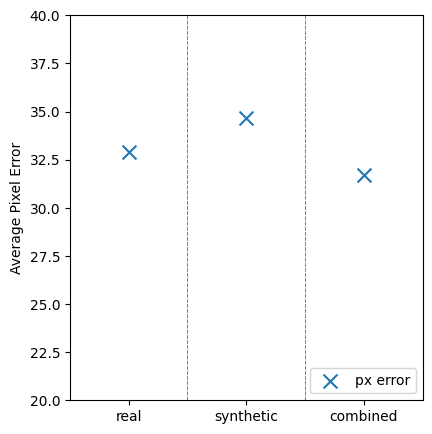

In [66]:
with open('../models/_train-2024-08-15_05-43-51-real-on-synthetic/20240815_054353/vis_data/COCO-combined.json') as f:
    combined_info = [json.loads(line) for line in f.readlines()]

with open('../models/_train-2024-08-15_05-25-27-real/20240815_052529/vis_data/COCO-real.json') as f:
    real_info = [json.loads(line) for line in f.readlines()]

with open('../models/_train-2024-08-15_05-08-10-synthetic/20240815_050812/vis_data/COCO-synthetic.json') as f:
    synthetic_info = [json.loads(line) for line in f.readlines()]

a
ap_synthetic = [x['coco/AP'] for x in synthetic_info]
ar_synthetic = [x['coco/AR'] for x in synthetic_info]

ap_real = [x['coco/AP'] for x in real_info]
ar_real = [x['coco/AR'] for x in real_info]

ap_combined = [x['coco/AP'] for x in combined_info]
ar_combined = [x['coco/AR'] for x in combined_info]
step = [x['step'] for x in combined_info]

# fig = plt.figure(figsize=(4,))
ax2 = fig.add_subplot(gs[0, 2:])
ax2.plot(step, ap_combined, linewidth=1, label='Combined COCO/AP')
ax2.plot(step, ar_combined, linewidth=1, label='Combined COCO/AR')
ax2.plot(step, ap_synthetic, linewidth=1, label='Synthetic COCO/AP')
ax2.plot(step, ar_synthetic, linewidth=1, label='Synthetic COCO/AR')
ax2.plot(step, ap_real, linewidth=1, label='Real COCO/AP')
ax2.plot(step, ar_real, linewidth=1, label='Real COCO/AR')

ax2.set_ylim([.2, 1])
ax2.set_xlabel('Step')
ax2.legend(loc='lower right')
ax2.grid(True)
# plt.savefig('ap-ar.svg', format='svg')
# plt.show()

plt.tight_layout()
plt.savefig('compare.svg')
plt.show()

## Extracting annotation photos to folders

In [ ]:
from pycocotools.coco import COCO

real_data_dir = '../datasets/20kp-sample98-data'
synthetic_data_dir = '../datasets/20kp-synthetic-data'
test_COCO = COCO('../datasets/annotations/20kp-sample98-test.json')
train_COCO = COCO('../datasets/annotations/20kp-sample98-train.json')
val_COCO = COCO('../datasets/annotations/20kp-sample98-val.json')

test_files = [i['file_name'] for i in test_COCO.loadImgs(test_COCO.getImgIds())]
train_files = [i['file_name'] for i in train_COCO.loadImgs(train_COCO.getImgIds())]
val_files = [i['file_name'] for i in val_COCO.loadImgs(val_COCO.getImgIds())]

In [ ]:
import shutil

[ shutil.copy(f'{real_data_dir}/{file}',
                f'{real_data_dir}/test')
                for file in test_files ]

[ shutil.copy(f'{real_data_dir}/{file}',
                f'{real_data_dir}/val')
                for file in val_files ]

[ shutil.copy(f'{real_data_dir}/{file}',
                f'{real_data_dir}/train')
                for file in train_files ]

## Averaging APs and ARs in 10 runs

In [4]:
coco_gt = COCO('../datasets/annotations/20kp-test.json')

In [15]:
real_aps = []
real_aps_50 = []
real_aps_75 = []
real_ars = []
real_ars_50 = []
real_ars_75 = []

for ann in sorted(glob.glob('../test_results_5fold/*-test_annotations-real_simillar_fold.json')):
    coco_dt = coco_gt.loadRes(ann)
    cocoEval = COCOeval(coco_gt, coco_dt, 'keypoints')
    cocoEval.params.kpt_oks_sigmas = np.ones((20,)) * .1
    cocoEval.evaluate()
    cocoEval.accumulate()
    cocoEval.summarize()
    real_aps.append(cocoEval.stats[0])
    real_aps_50.append(cocoEval.stats[1])
    real_aps_75.append(cocoEval.stats[2])
    real_ars.append(cocoEval.stats[5])
    real_ars_50.append(cocoEval.stats[6])
    real_ars_75.append(cocoEval.stats[7])

print('My results')
print(np.mean(real_aps))
print(np.mean(real_aps_50))
print(np.mean(real_aps_75))
print(np.mean(real_ars))
print(np.mean(real_ars_50))
print(np.mean(real_ars_75))

Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.853
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.904
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.853
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.880
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 1.000
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.933
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.880
Running per image evaluation...
Evaluate annotation type *keyp

In [16]:
syn_aps = []
syn_aps_50 = []
syn_aps_75 = []
syn_ars = []
syn_ars_50 = []
syn_ars_75 = []

for ann in sorted(glob.glob('../test_results_5fold/*-test_annotations-synthetic_varied_fold.json')):
    coco_dt = coco_gt.loadRes(ann)
    cocoEval = COCOeval(coco_gt, coco_dt, 'keypoints')
    cocoEval.params.kpt_oks_sigmas = np.ones((20,)) * .1
    cocoEval.evaluate()
    cocoEval.accumulate()
    cocoEval.summarize()
    syn_aps.append(cocoEval.stats[0])
    syn_aps_50.append(cocoEval.stats[1])
    syn_aps_75.append(cocoEval.stats[2])
    syn_ars.append(cocoEval.stats[5])
    syn_ars_50.append(cocoEval.stats[6])
    syn_ars_75.append(cocoEval.stats[7])

print('My results')
print(np.mean(syn_aps))
print(np.mean(syn_aps_50))
print(np.mean(syn_aps_75))
print(np.mean(syn_ars))
print(np.mean(syn_ars_50))
print(np.mean(syn_ars_75))

Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.873
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.896
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.873
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.900
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 1.000
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.933
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.900
Running per image evaluation...
Evaluate annotation type *keyp

In [17]:
com_aps = []
com_aps_50 = []
com_aps_75 = []
com_ars = []
com_ars_50 = []
com_ars_75 = []

for ann in sorted(glob.glob('../test_results_5fold/*-test_annotations-synthetic_on_real_fold.json')):
    coco_dt = coco_gt.loadRes(ann)
    cocoEval = COCOeval(coco_gt, coco_dt, 'keypoints')
    cocoEval.params.kpt_oks_sigmas = np.ones((20,)) * .1
    cocoEval.evaluate()
    cocoEval.accumulate()
    cocoEval.summarize()
    com_aps.append(cocoEval.stats[0])
    com_aps_50.append(cocoEval.stats[1])
    com_aps_75.append(cocoEval.stats[2])
    com_ars.append(cocoEval.stats[5])
    com_ars_50.append(cocoEval.stats[6])
    com_ars_75.append(cocoEval.stats[7])

print('My results')
print(np.mean(com_aps))
print(np.mean(com_aps_50))
print(np.mean(com_aps_75))
print(np.mean(com_ars))
print(np.mean(com_ars_50))
print(np.mean(com_ars_75))

Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.869
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.883
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.869
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.907
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 1.000
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.933
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.907
Running per image evaluation...
Evaluate annotation type *keyp

### Test

In [158]:
def get_normalized_pixel_distance(coco_gt, coco_dt):
    # Initialize a dictionary to store distances for each keypoint
    normalized_x_distances = []
    normalized_y_distances = []

    # Iterate through all image-category pairs
    for imgId in coco_gt.getImgIds():
        for catId in coco_gt.getCatIds():
            gt_list = coco_gt.loadAnns(coco_gt.getAnnIds(imgIds=[imgId], catIds=[catId], iscrowd=False))
            dt_list = coco_dt.loadAnns(coco_dt.getAnnIds(imgIds=[imgId], catIds=[catId]))

            if not gt_list or not dt_list:
                continue

            # Sort detections by score
            dt_list = sorted(dt_list, key=lambda x: -x['score'])

            for gt in gt_list:
                gt_keypoints = np.array(gt['keypoints']).reshape(-1, 3)  # Shape: [num_keypoints, 3]
                head_length = np.sqrt(  # We consider head length as the distance betweeen Head (kp#4) and Nose (kp#5) 
                    (gt_keypoints[4][0] - gt_keypoints[5][0]) ** 2 +
                    (gt_keypoints[4][1] - gt_keypoints[5][1]) ** 2
                )
                gt_vis = np.array(gt['keypoints'])[2::3]

                for dt in dt_list:
                    # print(dt['score'])
                    dt_keypoints = np.array(dt['keypoints']).reshape(-1, 3)  # Shape: [num_keypoints, 3]

                    # Calculate the pixel distance for each visible keypoint
                    x_distances = dt_keypoints[:, 0] - gt_keypoints[:, 0]
                    y_distances = dt_keypoints[:, 1] - gt_keypoints[:, 1]

                    x_distances[gt_vis < 1] = np.nan
                    y_distances[gt_vis < 1] = np.nan

                    x_distances = np.array(x_distances)
                    y_distances = np.array(y_distances)

                    normalized_x_distances.append(x_distances / head_length)
                    normalized_y_distances.append(y_distances / head_length)

    # Convert to numpy array for easier handling
    # keypoint_distances = np.array(keypoint_distances)
    # normalized_distances = np.array(normalized_distances)

    # # Calculate the average distance for each keypoint across all images
    # mean_distances_per_keypoint = np.nanmean(keypoint_distances, axis=0)
    # mean_normalized_distances_per_keypoint = np.nanmean(normalized_distances, axis=0)

    normalized_x_distances = np.array(normalized_x_distances)
    normalized_y_distances = np.array(normalized_y_distances)

    return normalized_x_distances, normalized_y_distances

In [175]:
keypoints_x = [np.float64(182.0997873587774), np.float64(388.8585985552321), np.float64(644.2665417979114), np.float64(856.0333518814774), np.float64(1049.1990232414869), np.float64(1193.7155625552718), np.float64(871.0573485428116), np.float64(655.7133963970231), np.float64(632.1042587863552), np.float64(586.3168403899085), np.float64(830.9933574459207), np.float64(862.4722075934777), np.float64(946.1773318494819), np.float64(435.36144536412326), np.float64(293.7066197001162), np.float64(227.88720575522416), np.float64(295.13747652500524), np.float64(177.09178847166606), np.float64(125.58094277566346), np.float64(171.3683611721102)]
keypoints_y = [np.float64(78.31159391488382), np.float64(95.48187581355137), np.float64(94.76644740110692), np.float64(105.49787358777405), np.float64(72.58816661532796), np.float64(232.128702590447), np.float64(237.85212989000286), np.float64(363.7675304802313), np.float64(471.79722075934774), np.float64(586.981195162909), np.float64(373.78352825445404), np.float64(503.27607090690486), np.float64(637.0611840340226), np.float64(453.1960820357913), np.float64(321.557254146007), np.float64(425.2943739504566), np.float64(569.8109132642414), np.float64(333.71953715756314), np.float64(463.92750822245847), np.float64(637.7766124464671)]

head_size = np.sqrt(
        (keypoints_x[4] - keypoints_x[5]) ** 2 +
        (keypoints_y[4] - keypoints_y[5]) ** 2
    )

In [198]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LinearSegmentedColormap
import glob

# Function to create a heatmap for a keypoint
def generate_heatmap(shape, keypoints, sigma=10):
    heatmap = np.zeros(shape)
    for x, y in keypoints:
        if 0 <= x < shape[1] and 0 <= y < shape[0]:  # Ensure keypoints are within the image bounds
            heatmap[int(y), int(x)] = 1
    heatmap = gaussian_filter(heatmap, sigma=sigma)
    return heatmap

# Load the image
img = mpimg.imread('figures/heatmap_hollow.png')  # Replace with your image

# Initialize the keypoints lists
real_predicted_keypoints = []
syn_predicted_keypoints = []
combined_predicted_keypoints = []

# Load the keypoints from json files
for real, syn, combined in zip(sorted(glob.glob('../test_results_5fold/*real_simillar_fold.json')),
                               sorted(glob.glob('../test_results_5fold/*synthetic_varied_fold.json')),
                               sorted(glob.glob('../test_results_5fold/*synthetic_on_real_fold.json'))):
    
    real_dt = coco_gt.loadRes(real)
    real_x_values, real_y_values = get_normalized_pixel_distance(coco_gt, real_dt)
    for x_dist, y_dist in zip(real_x_values, real_y_values):
        for (x, y) in zip(x_dist*head_size + keypoints_x, y_dist*head_size + keypoints_y):
            real_predicted_keypoints.append((x, y))
    
    syn_dt = coco_gt.loadRes(syn)
    syn_x_values, syn_y_values = get_normalized_pixel_distance(coco_gt, syn_dt)
    for x_dist, y_dist in zip(syn_x_values, syn_y_values):
        for (x, y) in zip(x_dist*head_size + keypoints_x, y_dist*head_size + keypoints_y):
            syn_predicted_keypoints.append((x, y))

    combined_dt = coco_gt.loadRes(combined)
    combined_x_values, combined_y_values = get_normalized_pixel_distance(coco_gt, combined_dt)
    for x_dist, y_dist in zip(combined_x_values, combined_y_values):
        for (x, y) in zip(x_dist*head_size + keypoints_x, y_dist*head_size + keypoints_y):
            combined_predicted_keypoints.append((x, y))

# Generate heatmaps for real, synthetic, and combined predictions
heatmap_real = generate_heatmap(img.shape[:2], real_predicted_keypoints, sigma=10)
heatmap_syn = generate_heatmap(img.shape[:2], syn_predicted_keypoints, sigma=10)
heatmap_combined = generate_heatmap(img.shape[:2], combined_predicted_keypoints, sigma=10)

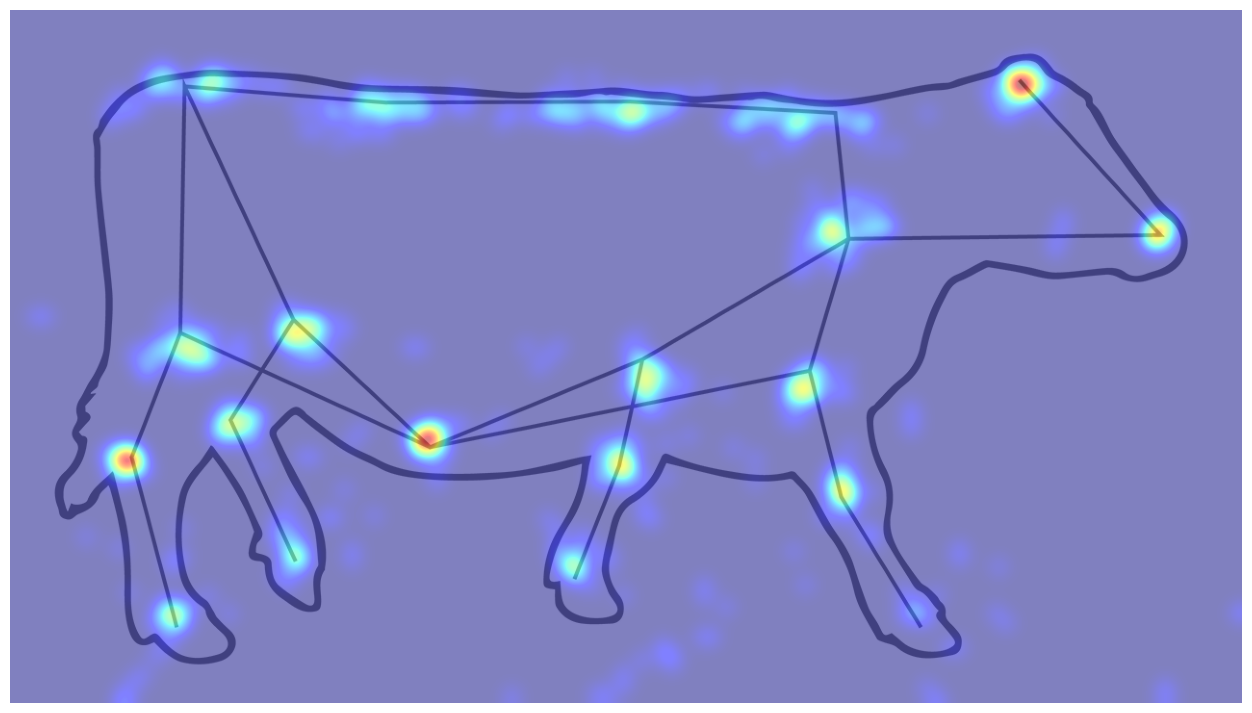

In [199]:
fig = plt.figure(figsize=(16, 9))
plt.imshow(img, alpha=.5)
plt.imshow(heatmap_real, cmap='jet', alpha=.5)
plt.axis('off')
plt.savefig('figures/heatmap_real.png', bbox_inches='tight', pad_inches=0, transparent=False)
plt.show()

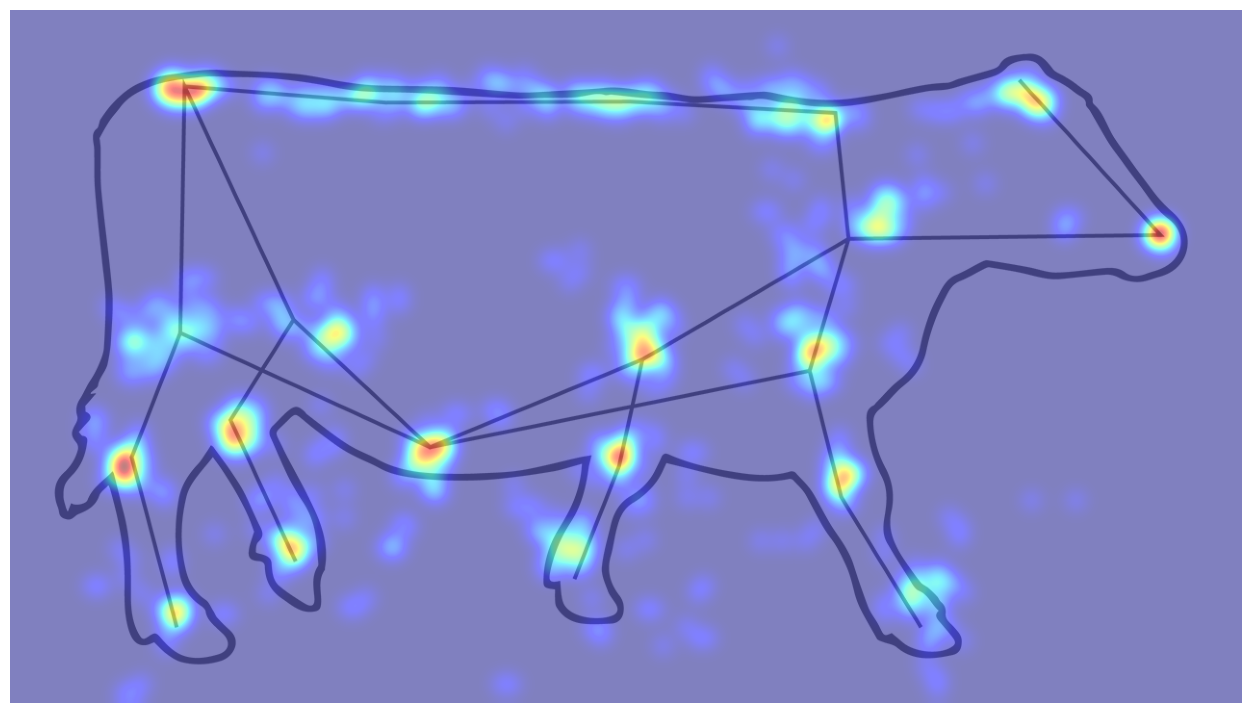

In [196]:
fig = plt.figure(figsize=(16, 9))
plt.imshow(img, alpha=.5)
plt.imshow(heatmap_syn, cmap='jet', alpha=.5)    # Red heatmap for synthetic predictions
plt.axis('off')
plt.savefig('figures/heatmap_syn.png', bbox_inches='tight', pad_inches=0, transparent=False)
plt.show()

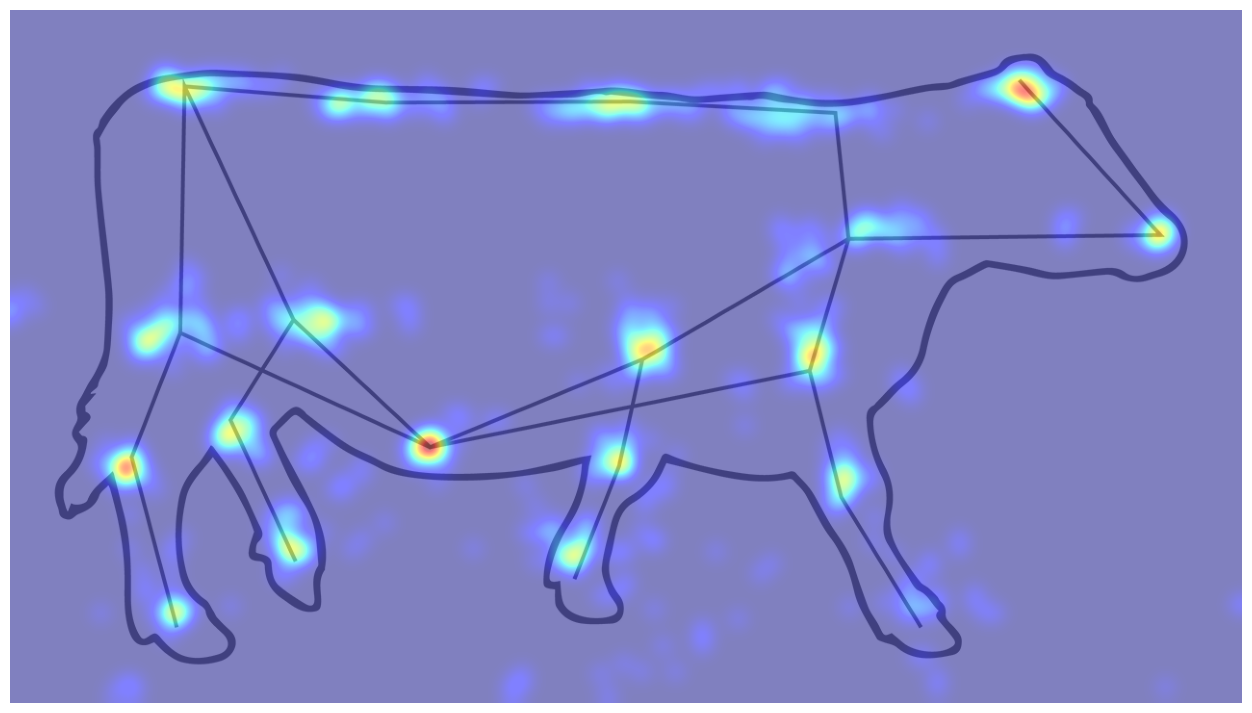

In [195]:
fig = plt.figure(figsize=(16, 9))
plt.imshow(img, alpha=.5)
plt.imshow(heatmap_combined, cmap='jet', alpha=.5)
plt.axis('off')
plt.savefig('figures/heatmap_combined.png', bbox_inches='tight', pad_inches=0, transparent=False)
plt.show()

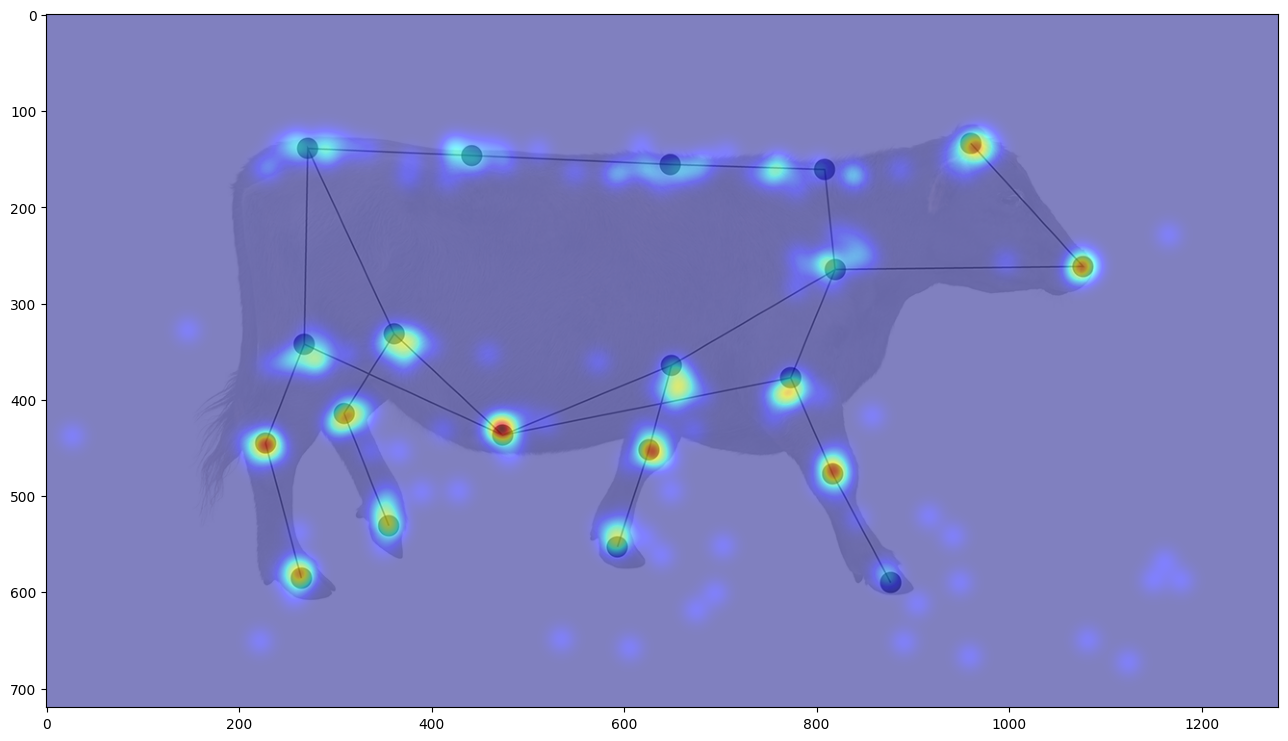

In [174]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.ndimage import gaussian_filter

# Function to create a heatmap for a keypoint
def generate_heatmap(shape, keypoints, sigma=10):
    heatmap = np.zeros(shape)
    for x, y in keypoints:
        if 0 <= x < shape[1] and 0 <= y < shape[0]:  # Ensure keypoints are within the image bounds
            heatmap[int(y), int(x)] = 1
    heatmap = gaussian_filter(heatmap, sigma=sigma)
    return heatmap

# Load the image
img = mpimg.imread('figures/heatmap.png')  # Replace with your image

predicted_keypoints = []

for x_dist, y_dist in zip(real_x_values, real_y_values):
    for (x, y) in zip(x_dist*head_size + keypoints_x, y_dist*head_size + keypoints_y):
        predicted_keypoints.append((x, y))

heatmap = generate_heatmap(img.shape[:2], predicted_keypoints, sigma=10)

fig, ax = plt.subplots(figsize=(16, 9))
ax.imshow(img)

ax.imshow(heatmap, cmap='jet', alpha=0.5)

plt.show()
